In [45]:
import numpy as np
import regex as re
import pandas as pd
import pickle
from collections import defaultdict


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from matplotlib import colors
from matplotlib.lines import Line2D


#from netwulf import visualize
#import netwulf as nw
#from numba import jit

#import pydot

from fa2 import ForceAtlas2
from graph_functions import create_bipartite_graph, set_politician_attributes, create_color_map
import networkx as nx
#import community for community detection
import community as community_louvain

import datetime

### Goal: investigate which politicians are present the entire time for each period and establish some threshold to remove nodes that are not sufficiently present

In [46]:
#load data from df_law_clean.pickle
with open('df_law_clean.pickle', 'rb') as f:
    df = pickle.load(f)


### The problem of politicians that have only been part of a portion of a given period - scewed data
Since we are creating a unipartite graph and relying on the weights between politicians in a given period to determine how much they collaborate, based solely on the shared amount of 'yes votes', it is a problem if we have some politicians in our dataset with very few votes in a given period. Hence, not having voting, counts equally much against being in a community with a yes voter, as simply not being present. One way to fix this, would be to set some empirical values as to influence the weight so that a yes-no vote between two politicians for the same law provides a more negative score, than a yes-absent. 

Even with weighting the vote types, we are however still faced with the problem of politicians that have less than 100% votes when including both yes, no, absent and blank votes. This could happen if there was some mistake in the registration of votes, but will certaintly happen when a politician due to serius sickness, maternity leave, quitting etc. is no longer part of the parlaimentary work, or when a substitution enters in midst of a period. If we include politicians that for whatever reason may just have participated in some % of the votings that year, we expect that this wil scew our community detection significantly as the weights will make it appear as if this person disagree with the majority of the other politicians that they in fact agreed with (given that much fewer edges will be created for a politician that did fewer votings). 

A solution would be to scale the weight of the edges in a network, based on the % of total votings they have been part of in that given period (including both absent, blank, yes and no votes), or simply remove politicians that have only been partially involved in the votings for a given year (perhaps at some reasonable threshold).

### Removing politicians that have not participated in the majorty of votings
We decided to proceed with the approach of removing politicians

After having check a few periods, it seems to make sense to make a threshold at 90% of max votes

In [47]:
#This function takes a periode_id and calculates the 90% threshold for that period
def threshold_periode(periode_id):
    df_periode = df[df['periode_id'] == periode_id]
    dict_politicians = defaultdict()
    for index, row in df_periode.iterrows():
        for vote in row['votes_adjusted']:
            if vote['aktørid'] not in dict_politicians:
                dict_politicians[vote['aktørid']] = 1
            else:
                dict_politicians[vote['aktørid']] += 1
    return 0.9 * max(dict_politicians.values())


In [48]:
#This function takes a periode_id and returns a list of politicians who have voted more than 90% of the time
def active_politicians(periode_id):
    df_periode = df[df['periode_id'] == periode_id]
    dict_politicians = defaultdict()
    for index, row in df_periode.iterrows():
        for vote in row['votes_adjusted']:
            if vote['aktørid'] not in dict_politicians:
                dict_politicians[vote['aktørid']] = 1
            else:
                dict_politicians[vote['aktørid']] += 1
    threshold = 0.9 * max(dict_politicians.values())

    return [key for key, value in dict_politicians.items() if value > threshold]

In [49]:
#This function does the same as above, but without the threshold
def all_politicians(periode_id):
    df_periode = df[df['periode_id'] == periode_id]
    dict_politicians = defaultdict()
    for index, row in df_periode.iterrows():
        for vote in row['votes_adjusted']:
            if vote['aktørid'] not in dict_politicians:
                dict_politicians[vote['aktørid']] = 1
            else:
                dict_politicians[vote['aktørid']] += 1
    return [key for key, value in dict_politicians.items()]

In [50]:
#We find all unique periode_ids
periode_ids = df['periode_id'].unique()

#We make a dict of active politicians for each periode_id
dict_active_politicians = defaultdict()
for periode_id in periode_ids:
    dict_active_politicians[periode_id] = active_politicians(periode_id)


In [51]:
#create a list comprehension that creates a copy of the votes_adjusted column, but include politicians that are active in the period according to the dict_active_politicians

df['votes_adjusted_active'] = [ [vote for vote in row['votes_adjusted'] if vote['aktørid'] in dict_active_politicians[row['periode_id']]] for index, row in df.iterrows()]


In [52]:
#Initialize defaultdict for politicians
politicians_lost = defaultdict()
politicians_active = defaultdict()

for period in periode_ids:
    #Number of politicans who voted in each vote
    all_pol = all_politicians(period)
    active_pol = active_politicians(period)
    politicians_lost[period] = len(all_pol) - len(active_pol)
    politicians_active[period] = len(active_pol)


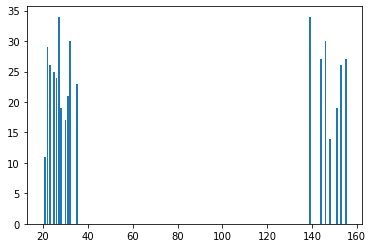

The average number of politicians dropped per period is 19.818181818181817


In [53]:
#Make a histogram of the number of politicians lost per period with periode_id as x-axis
plt.bar(politicians_lost.keys(), politicians_lost.values())
plt.show()
print('The average number of politicians dropped per period is', np.mean(list(politicians_lost.values())))

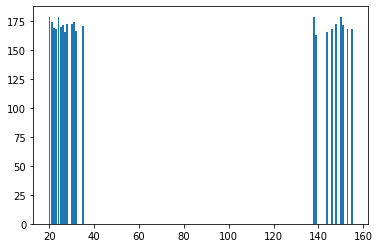

The average number of politicians that we consider per period is 171.4090909090909


In [54]:
#Make a histogram of the number of active politicians with periode_id as x-axis
plt.bar(politicians_active.keys(), politicians_active.values())
plt.show()
print('The average number of politicians that we consider per period is', np.mean(list(politicians_active.values())))

Given that there are at any time 179 politicians in the parlaiment, we believe that by sorting off less than 8 politicians pr. period on average, our data analysis will still be representative. 

In [56]:
df['votes_adjusted_active'].isna().sum()

0

In [58]:
#pickle the new dataframe
#with open('df_law_active.pickle', 'wb') as f:
#   pickle.dump(df, f)

#load data from df_law_active.pickle
with open('df_law_active.pickle', 'rb') as f:
    df = pickle.load(f)

In [59]:
df['votes_adjusted_active'].isna().sum()

0

In [265]:
#create a networkx graph for period 32
df32 = df[df['periode_id'] == 32]

#OBS BRUGER IKKE ACTIVE POLITCIANS VOTING BECAUSE OF THE IMPLEMENTATION IN SCRAPE LOVE

G = create_bipartite_graph(df32)

#set attributes for politicians
G = set_politician_attributes(G)

In [266]:
#Function to check for isolate nodes
def remove_isolate_nodes(G):
    isolate_nodes = list(nx.isolates(G))
    if len(isolate_nodes) > 0:
        G.remove_nodes_from(isolate_nodes)
        print(f'Removed {len(isolate_nodes)} isolate nodes')
    else:
        print('No isolate nodes')
    return G

In [267]:
#clean graph
#remove the isolated nodes
remove_isolate_nodes(G)

law_nodes, politician_nodes = nx.bipartite.sets(G)

color_map = create_color_map() #defined in graph_functions.py

No isolate nodes


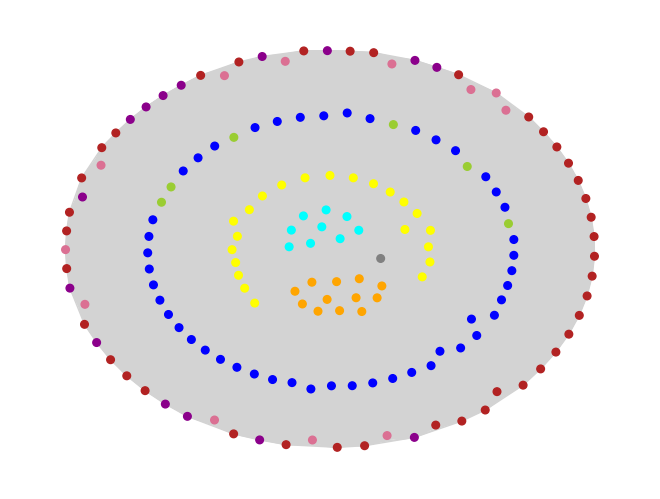

In [268]:
G_uni = nx.bipartite.weighted_projected_graph(G, politician_nodes)

pos = nx.kamada_kawai_layout(G_uni)
#pos = nx.fruchterman_reingold_layout(G_uni, k=0.5, iterations=50)

nx.draw(G_uni, node_size = 30, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [G_uni.nodes[node]['color'] for node in G_uni.nodes()])

In [269]:
#Do clustering on the graph using the Louvain algorithm
partition = community_louvain.best_partition(G_uni)

#print number of clusters
print(len(set(partition.values())))


3


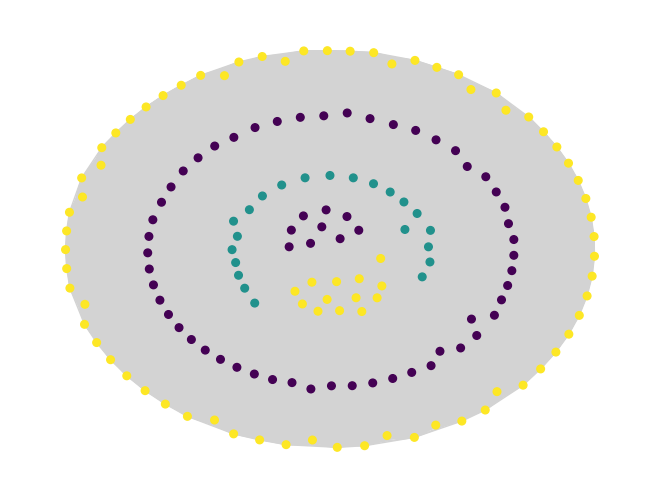

In [270]:
#plot the graph with the clusters
pos = nx.kamada_kawai_layout(G_uni)

nx.draw(G_uni, node_size = 30, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [partition[node] for node in G_uni.nodes()])
plt.show()

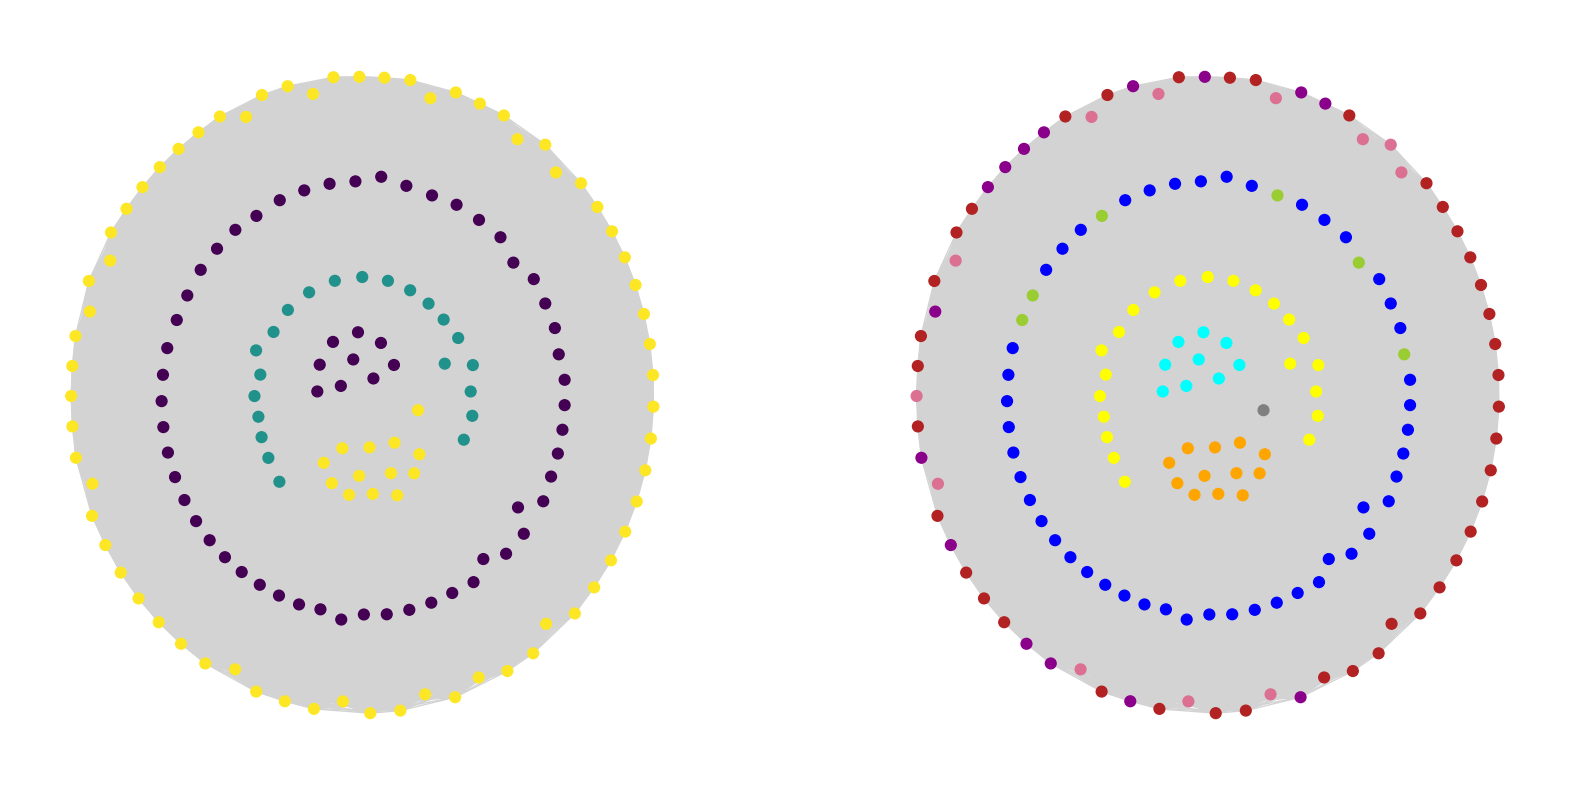

In [271]:
#plot the graph with the clusters in a subgraph
#two horizontally stacked subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

#plot the networkx graph in ax1 
pos = nx.kamada_kawai_layout(G_uni, weight='weight', scale=100)
nx.draw(G_uni, node_size = 60, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [partition[node] for node in G_uni.nodes()], ax=ax1)
#plot it with party colors
nx.draw(G_uni, node_size = 60, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [G_uni.nodes[node]['color'] for node in G_uni.nodes()], ax=ax2)

In [272]:
#Who is the grey (out of folketingsgruppe) politician?
for node in G_uni.nodes():
    if G_uni.nodes[node]['color'] == 'grey':
        #print name attribute of the node
        print(G_uni.nodes[node]['name'])

Uffe Elbæk


In [273]:
#Uffe Elbæk left radikale venstre in 2013, and this period covers 2014-2015 - makes sense.

In [274]:
#import backbone
import backbone_network as bb

#make a backbone network
G_backbone = bb.get_graph_backbone(G_uni, 0.5)


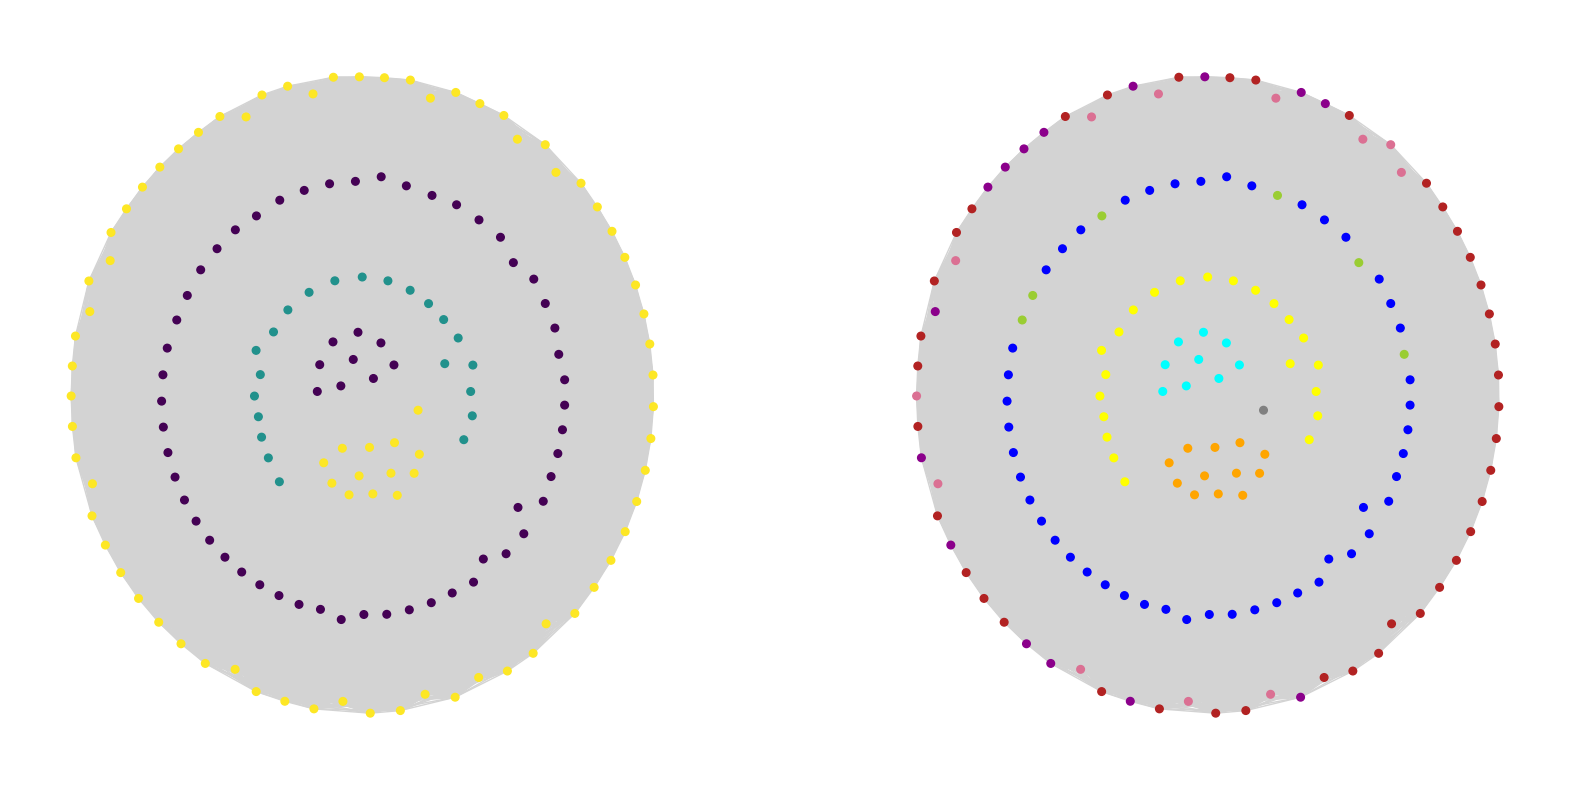

In [275]:
#plot the backbone network
pos = nx.kamada_kawai_layout(G_backbone, weight='weight', scale=100)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
nx.draw(G_backbone, node_size = 30, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [partition[node] for node in G_backbone.nodes()], ax=ax1)
nx.draw(G_backbone, node_size = 30, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [G_backbone.nodes[node]['color'] for node in G_backbone.nodes()], ax=ax2)


### We first plot the clustering over time for each period and check if the same parties are in the same clusters and if certain individuals are not in the same cluster as their party

In [276]:
#loading politician info from pickle politician_df_clean.pkl
with open('politician_df_clean.pkl', 'rb') as f:
    politician_df = pickle.load(f)

politician_df.head()

#set the index to politician_id
politician_df = politician_df.set_index('politician_id')

c:\Users\rune7\anaconda3\envs\css\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [277]:
#We make a dict where we have the periode_id as key and the aktør_id with their party and partition as value
partition_all_periods = pd.DataFrame()

#unique periods
periods = df['periode_id'].unique()

trouble_ids = []

for periode_id in periods:
    print(f'Working on periode_id {periode_id}')

    #get the df for the periode_id
    df_period = df[df['periode_id'] == periode_id]

    G = create_bipartite_graph(df_period)

    #set attributes for politicians
    G = set_politician_attributes(G)

    #clean graph
    #remove the isolated nodes
    remove_isolate_nodes(G)
    
    law_nodes, politician_nodes = nx.bipartite.sets(G)

    color_map = create_color_map() #defined in graph_functions.py

    G_uni = nx.bipartite.weighted_projected_graph(G, politician_nodes)

    #Do clustering on the graph using the Louvain algorithm
    partition = community_louvain.best_partition(G_uni)

    
    period_dict = defaultdict()
    for id in partition.keys():
        try:
            #get party of id
            party = politician_df.loc[id]['party'][periode_id]
            period_dict[id] = [party, partition[id],periode_id]
            period_df = pd.DataFrame.from_dict(period_dict, orient='index', columns=['party', 'partition', 'periode_id'])
        except KeyError:
            trouble_ids.append({'id':id, 'periode_id':periode_id})
            print(f'KeyError for id {id} and periode_id {periode_id}')
            pass

    
    partition_all_periods = partition_all_periods.append(period_df)



Working on periode_id 32
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 31
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 30
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 28
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 35
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 27
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)
C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 138
No isolate nodes
Working on periode_id 139
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 144
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 146
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 26
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)
C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 24
No isolate nodes
Working on periode_id 25
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 23
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 22
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 21
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 20
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 148
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 150
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 151
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 153
No isolate nodes
KeyError for id 19809 and periode_id 153
Working on periode_id 155


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


In [278]:
#This function finds non-conformers for all parties for all periods
def find_non_conformers(partition_all_periods):
    non_conformers = pd.DataFrame()
    parties = partition_all_periods['party'].unique()
    for party in parties:
        #get subset of partition_all_periods for the party
        df_party = partition_all_periods[partition_all_periods['party'] == party]
        #get the partition number for the party for each period
        periods = df_party['periode_id'].unique()
        for period in periods:
            #get subset of partition_all_periods for the party and period
            df_period = df_party[df_party['periode_id'] == period]
            #get the partition number for the party
            party_partition_number = df_period['partition'].unique()[0]
            #get the subset of partition_all_periods for the party and period where the partition number is not the same as the party
            non_conformers = non_conformers.append(df_period[df_period['partition'] != party_partition_number])
    return non_conformers

non_conformers = find_non_conformers(partition_all_periods)

#We add the politician name to the non_conformers
for id in non_conformers.index:
    non_conformers.loc[id, 'politician_name'] = politician_df.loc[id]['politician_name']
non_conformers

C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2348444063.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_conformers = non_conformers.append(df_period[df_period['partition'] != party_partition_number])
C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2348444063.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_conformers = non_conformers.append(df_period[df_period['partition'] != party_partition_number])
C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2348444063.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_conformers = non_conformers.append(df_period[df_period['partition'] != party_partition_number])
C:\Users\rune7\AppData\Local\Temp\ipykernel_19836\2348444063.py:16: FutureWarning: The fram

,party,partition,periode_id,politician_name
44,Enhedslisten,1,153,Henning Hyllested
16503,Socialdemokratiet,1,153,Anne Paulin
152,Socialdemokratiet,1,153,Ida Auken
19637,"Venstre, Danmarks Liberale Parti",1,153,Kenneth Mikkelsen
19807,"Venstre, Danmarks Liberale Parti",1,153,Anne Rasmussen
18701,"Venstre, Danmarks Liberale Parti",1,153,Marie Bjerre
219,Socialistisk Folkeparti,1,153,Lisbeth Bech-Nielsen
4969,Radikale Venstre,1,25,Jørgen Poulsen
18728,Radikale Venstre,1,153,Anne Sophie Callesen
17141,Det Konservative Folkeparti,1,153,Brigitte Klintskov Jerkel


In [246]:
#We check which partition people from socialdemokratiet are in
partition_all_periods[partition_all_periods['party'] == 'Socialdemokratiet'].value_counts('partition')


partition
0    537
1    305
2      9
dtype: int64

In [240]:

#This means we have to change it such that the partition number is consistent across periods

#First we find out which partitition number is most common for socialdemokratiet for each period
soc_partition = partition_all_periods[partition_all_periods['party'] == 'Socialdemokratiet'].groupby('periode_id').agg(lambda x:x.value_counts().index[0])

In [241]:
#For all periods where the partition number is not 1, we change it to 1 and we change the partition number for the other parties accordingly
for periode_id in soc_partition.index:
    #get subset of partition_all_periods for the periode_id
    df_period = partition_all_periods[partition_all_periods['periode_id'] == periode_id]
    #get the partition number for socialdemokratiet
    soc_partition_number = soc_partition.loc[periode_id]['partition']
    #if the partition number is not 1, we change it to 1
    if soc_partition_number != 1:
        #We first move all the parities with soc_partition_number to partition 10 (which is not used)
        partition_all_periods.loc[(partition_all_periods['periode_id'] == periode_id) & (partition_all_periods['partition'] == soc_partition_number), 'partition'] = 10
        #We then move all the parties with partition number 1 to soc_partition_number
        partition_all_periods.loc[(partition_all_periods['periode_id'] == periode_id) & (partition_all_periods['partition'] == 1), 'partition'] = soc_partition_number
        #We then move all the parties with partition number 10 to 1
        partition_all_periods.loc[(partition_all_periods['periode_id'] == periode_id) & (partition_all_periods['partition'] == 10), 'partition'] = 1

In [242]:
#We check that it worked
partition_all_periods[partition_all_periods['party'] == 'Socialdemokratiet'].value_counts('partition')
#This means that two persons from Socialdemokratiet were not assigned to the same parititon as the rest of the party


partition
1    839
2     11
0      1
dtype: int64

In [181]:
#In general there are quite few non-conformers. So when plotting the graph, we will simply plot each party as a group

#We save the partition_all_periods as a pickle
partition_all_periods.to_pickle('partition_all_periods.pkl')

In [182]:
#We exctract the most common partition for all parties for all periods in partition_all_periods
party_partition = partition_all_periods.groupby(['party', 'periode_id']).agg(lambda x:x.value_counts().index[0])
party_partition['partition']

party                             periode_id
Alternativet                      138           1
                                  139           1
                                  144           2
                                  146           2
                                  148           0
                                               ..
Venstre, Danmarks Liberale Parti  148           2
                                  150           1
                                  151           0
                                  153           0
                                  155           0
Name: partition, Length: 223, dtype: int64

In [183]:
common_partition = defaultdict()
#unique parties 
parties = partition_all_periods['party'].unique()
#drop Tjóðveldisflokkurin, 'Inuit Ataqatigiit',  'Sambandsflokkurin', 'Siumut', 'Kristendemokraterne',Fólkaflokkurin and 'Uden for folketingsgrupperne',
parties = parties[~np.isin(parties, ['Tjóðveldisflokkurin', 'Inuit Ataqatigiit', 'Sambandsflokkurin', 'Siumut', 'Kristendemokraterne','Fólkaflokkurin',  'Uden for folketingsgrupperne'])]

In [184]:
party_period = defaultdict()
periods = partition_all_periods['periode_id'].unique()
for party in parties:
    #get a subset of party_partition for the party
    df_party = party_partition.loc[party]
    for period in periods:
        #Check that df_party has the period
        if period in df_party.index:
            #get the partition number for the party and period
            party_period[(party, period)] = df_party.loc[period]['partition']
        else:
            #if the party did not exist in the period, we set the partition number to 0
            party_period[(party, period)] = None

In [137]:
party_period

defaultdict(None,
            {('Enhedslisten', 32): 0,
             ('Enhedslisten', 31): 0,
             ('Enhedslisten', 30): 0,
             ('Enhedslisten', 28): 0,
             ('Enhedslisten', 35): 0,
             ('Enhedslisten', 27): 0,
             ('Enhedslisten', 138): 0,
             ('Enhedslisten', 139): 0,
             ('Enhedslisten', 144): 2,
             ('Enhedslisten', 146): 2,
             ('Enhedslisten', 26): 0,
             ('Enhedslisten', 24): None,
             ('Enhedslisten', 25): 0,
             ('Enhedslisten', 23): 0,
             ('Enhedslisten', 22): 0,
             ('Enhedslisten', 21): 0,
             ('Enhedslisten', 20): 0,
             ('Enhedslisten', 148): 2,
             ('Enhedslisten', 150): 0,
             ('Enhedslisten', 151): 0,
             ('Enhedslisten', 153): 0,
             ('Enhedslisten', 155): 0,
             ('Socialdemokratiet', 32): 0,
             ('Socialdemokratiet', 31): 0,
             ('Socialdemokratiet', 30): 0,
     

### We now plot the parties clustering over time
First we identify the dates corresponding to each period

In [101]:
#We look through the df dato_sagstrin that is a datetime format and we extract the min and max date for each periode_id
periods = df['periode_id'].unique()
periods_dict = defaultdict()
for period in periods:
    #get subset of dato_sagstrin for the period
    df_period = df[df['periode_id'] == period]
    #get the min and max date
    min_date = df_period['dato_sagstrin'].min()
    #convert to datetime
    min_date = datetime.datetime.strptime(min_date[:-9], '%Y-%m-%d')
    max_date = df_period['dato_sagstrin'].max()
    #convert to datetime
    max_date = datetime.datetime.strptime(max_date[:-9], '%Y-%m-%d')
    #find the date in the middle of the period
    middle_date = min_date + (max_date - min_date)/2
    periods_dict[period] = [min_date, middle_date, max_date]
 



In [95]:
periods

array([ 32,  31,  30,  28,  35,  27, 138, 139, 144, 146,  26,  24,  25,
        23,  22,  21,  20, 148, 150, 151, 153, 155], dtype=int64)

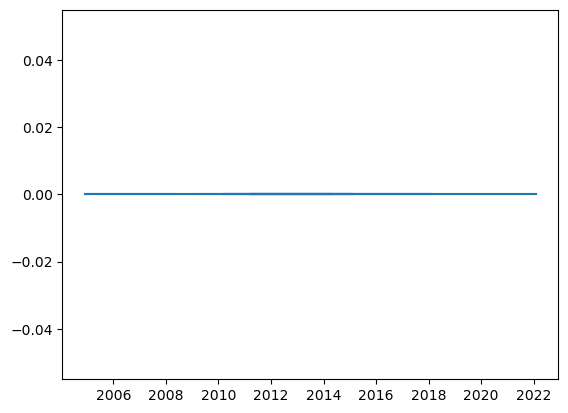

In [143]:
#We now plot Socialdemokratiet and Venstre for all periods
#on the x-axis we have the date in the middle of the period
#on the y-axis we have the partition number

#We plot Socialdemokratiet
#We get the partition number for Socialdemokratiet for each period
partition_number = [party_period[('Socialdemokratiet', period)] for period in periods]
#We get the middle date for each period
middle_date = [periods_dict[period][1] for period in periods]
#We plot the partition number for Socialdemokratiet for each period
plt.plot(middle_date, partition_number, label = 'Socialdemokratiet')

In [145]:
color_map = create_color_map()


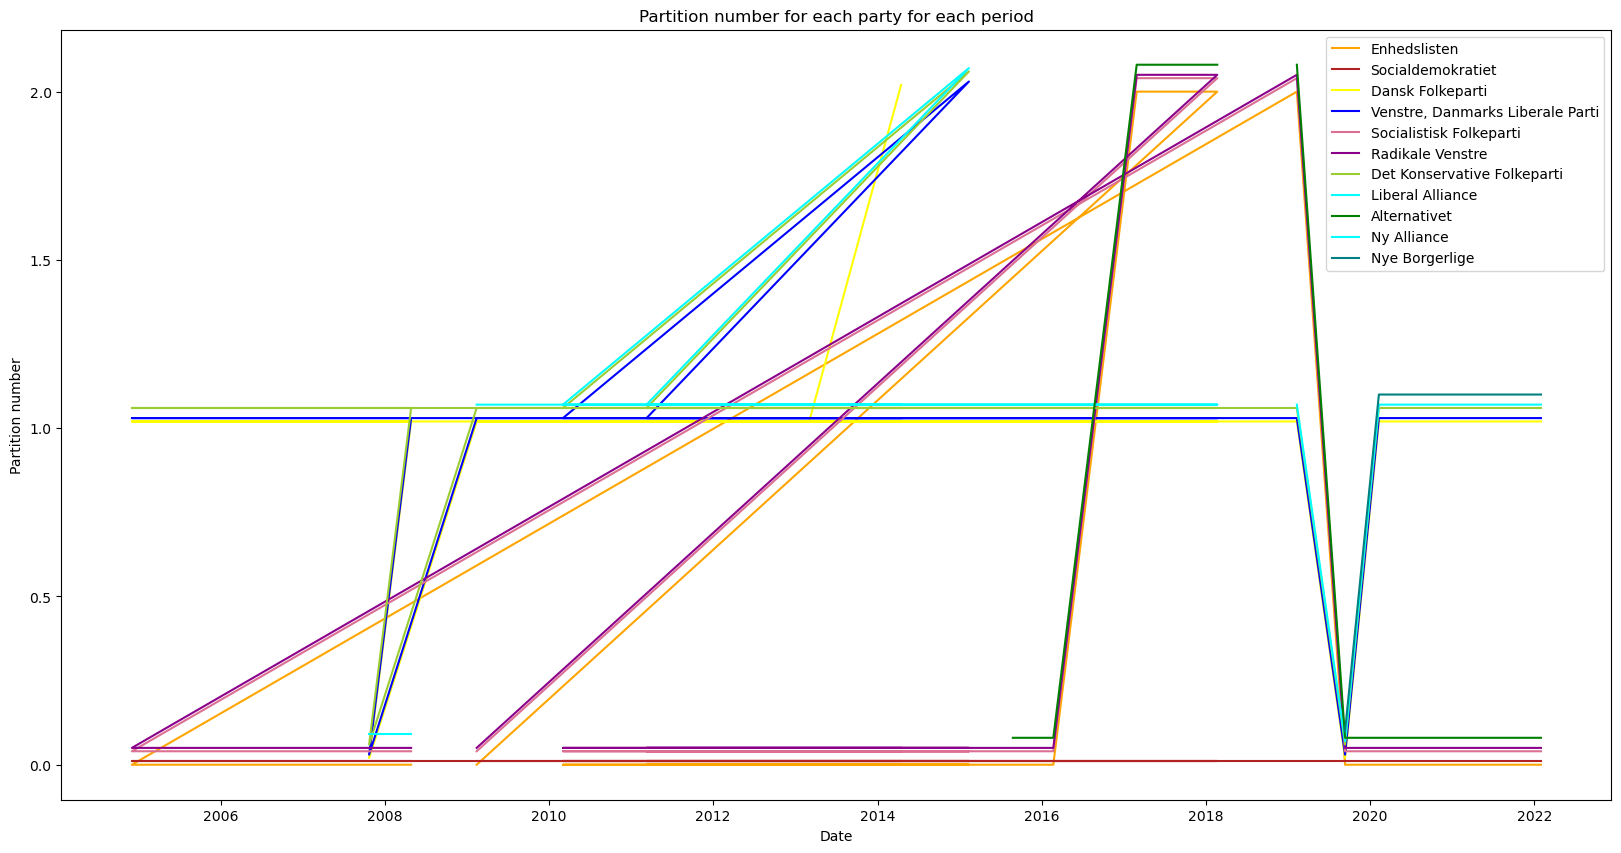

In [151]:
#We plot all the parties

fig, ax = plt.subplots(figsize=(20,10))
middle_date = [periods_dict[period][1] for period in periods]
offset = 0
for party in parties:
    #We get the partition number for the party for each period
    partition_number = [party_period[(party, period)] for period in periods]
    #add offset if the entries in partition_number are not None
    partition_number = [x + offset if x is not None else x for x in partition_number]
    #We plot the partition number for the party for each period
    ax.plot(middle_date, partition_number, label = party, color = color_map[party])
    offset = offset + 0.01
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Partition number')
ax.set_title('Partition number for each party for each period')
plt.show()
